In [1]:
import pandas as pd, numpy as np,xarray as xr
from pathlib import Path
import re, yaml, copy, json
import helper, events_methods
import subprocess


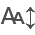

In [2]:
import itables
itables.init_notebook_mode(all_interactive=True )
itables.options.maxBytes = "1MB"
itables.options.lengthMenu = [25, 10, 50, 100, 200]
# itables.options.scrollY="200px"
# itables.options.scrollCollapse=True
# itables.options.paging=False
itables.options.column_filters = "footer"
itables.options.layout={"topEnd": None, "top1": "searchBuilder"}

In [3]:
base = Path("/home/julienb/Documents/database_scripts/database_scripts_test/spike2files/")
spike2_path = helper.singleglob(base, "*.smrx")
info_path = helper.singleglob(base, "*.yaml", search_upward_limit=Path("/home/julienb/Documents/database_scripts/database_scripts_test/spike2files/"))
res_events_path = base/"events.tsv"
info_path

PosixPath('/home/julienb/Documents/database_scripts/database_scripts_test/spike2files/rat_model.yaml')

In [4]:
if not spike2_path.with_suffix("").with_stem(spike2_path.stem+ "_data").exists():
    subprocess.run(["/home/julienb/miniconda3/envs/spike2/bin/smrx2python", "-i", str(spike2_path)])
channels = pd.read_csv(spike2_path.with_suffix(".tsv"), sep="\t")
channels

name        data_kind  smrx_channel_num           smrx_type   unit  \
0   TTL Lase  RegularSampling                 0        DataType.Adc   Volt   
1       lick  RegularSampling                 1        DataType.Adc   Volt   
2   SpkGlass  RegularSampling                 2        DataType.Adc   Volt   
3   EcoGleft  RegularSampling                 3        DataType.Adc   Volt   
4   LED Face            Event                 4  DataType.EventBoth    NaN   
5     Reward            Event                 5  DataType.EventBoth    NaN   
6   Pad_Gauc            Event                 6  DataType.EventBoth    NaN   
7   Pad Droi            Event                 7  DataType.EventBoth    NaN   
8   L1_Gauch            Event                 8  DataType.EventBoth    NaN   
9   Son Gauc            Event                11  DataType.EventBoth    NaN   
10  LaserOut  RegularSampling                12        DataType.Adc    NaN   
11     Sound  RegularSampling                14        DataType.Adc    NaN   

      n_data       fs  
0    1182481   1000.0  
1    1182481   1000.0  
2   23649601  20000.0  
3    1182480   1000.0  
4        314      NaN  
5        124      NaN  
6       1008      NaN  
7       1474      NaN  
8         86      NaN  
9        126      NaN  
10  11824801  10000.0  
11  23649601  20000.0

In [5]:
info = yaml.safe_load(info_path.open("r"))
info

{'discretize': [{'dest_channel': 'lick_ev',
   'channel': 'lick',
   'method': 'interupted_sine_wave',
   'method_params': {'sine_fs': 50}}],
 'processing': [{'duplicate_over': {'channel_name': ['.*']},
   'event_name': '{channel_name}',
   'method': 'input_binary_wave',
   'method_params': {'filter_expr': 'channel_name=="{channel_name}"',
    'state_expr': 'State==1'}}],
 'display': {'rename': {'PAD_P': 'PAD_left',
   'PAD_V': 'PAD_right',
   'L1': 'LEVER_left',
   'L2': 'LEVER_right'}}}

In [6]:
discretize = events_methods.EventProcessing.process_info(channels["name"].to_list(), info["discretize"], dest_name="dest_channel")
chans = set(channels["name"].to_list())
regular_chans =  set(channels["name"].loc[channels["data_kind"] == "RegularSampling"].to_list())
dkeys = {v["channel"] for v in discretize.values()}
if not dkeys.issubset(chans):
    raise Exception(f"Some source channels where not found {dkeys - chans}")
if not dkeys.issubset(regular_chans):
    raise Exception(f"Some source channels are not regular (continuous) {dkeys - regular_chans}")
pd.DataFrame(list(discretize.values()))

dest_channel channel                method    method_params
0      lick_ev    lick  interupted_sine_wave  {'sine_fs': 50}

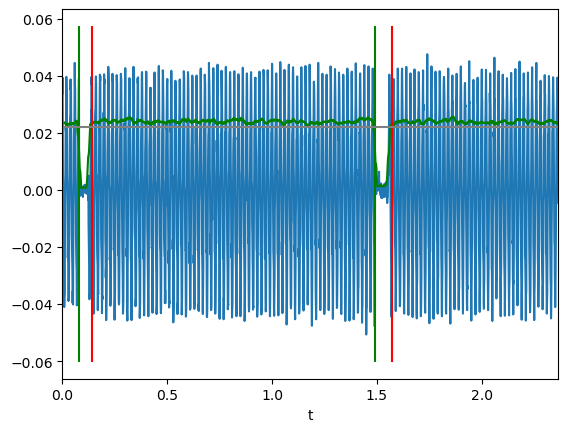

t channel_name  State
0        0.081      lick_ev      1
1        0.142      lick_ev      0
2        1.492      lick_ev      1
3        1.572      lick_ev      0
4       14.438      lick_ev      1
...        ...          ...    ...
2339  1179.803      lick_ev      0
2340  1181.212      lick_ev      1
2341  1181.214      lick_ev      0
2342  1182.107      lick_ev      1
2343  1182.174      lick_ev      0

[2344 rows x 3 columns]

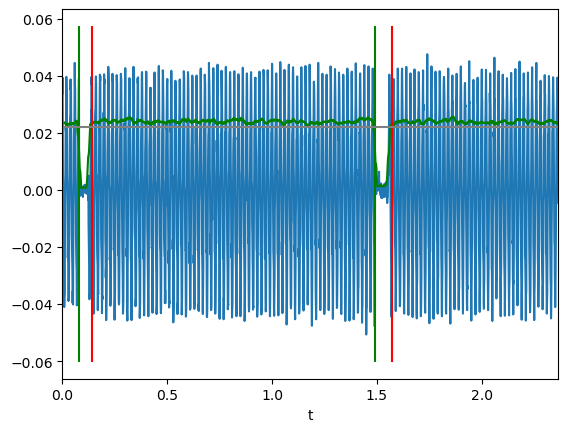

In [7]:
discretized = []
chans=[]
for dest_chan, item in discretize.items():
    npy = np.load(spike2_path.with_suffix("").with_stem(spike2_path.stem+ "_data") /( item["channel"] + ".npy"))
    if len(channels[channels["name"] == item["channel"]].index) != 1:
        raise Exception("Problem")
    meta = channels[channels["name"] == item["channel"]].iloc[0, :]
    data = xr.DataArray(npy, dims=["t"])
    data["t"] = np.arange(npy.size)/meta["fs"]
    # display(data)
    events, to_display = events_methods.Discretize.call(item["method"],data, item)
    display(to_display)
    discretized.append(events)
    chans.append(dest_chan)
    # display(events)
discretized = pd.concat(discretized).reset_index(drop=True)
discretized

In [8]:
event_df = [discretized]
for _, row in channels.loc[channels["data_kind"]=="Event"].iterrows():
    data = np.load(spike2_path.with_suffix("").with_stem(spike2_path.stem+ "_data") /(row["name"] + ".npy"))
    chans.append(row["name"])
    if row["smrx_type"] == "DataType.EventBoth":
        dr = pd.DataFrame().assign(t=data[:, 0], channel_name=row["name"], State=1)
        dd = pd.DataFrame().assign(t=data[: , 1], channel_name=row["name"], State=0)
        d = pd.concat([dd, dr])
    else: raise Exception("unhandled event type")
    event_df.append(d)
event_df = pd.concat(event_df).sort_values("t").reset_index(drop=True)
event_df

        

t channel_name  State
0        0.081000      lick_ev      1
1        0.142000      lick_ev      0
2        1.302065     Pad Droi      1
3        1.325920     Pad Droi      0
4        1.492000      lick_ev      1
...           ...          ...    ...
5471  1179.803000      lick_ev      0
5472  1181.212000      lick_ev      1
5473  1181.214000      lick_ev      0
5474  1182.107000      lick_ev      1
5475  1182.174000      lick_ev      0

[5476 rows x 3 columns]

In [9]:
event_spec = events_methods.EventProcessing.process_info(chans, info["processing"])
pd.DataFrame(list(event_spec.values()))

event_name             method  \
0    lick_ev  input_binary_wave   
1   LED Face  input_binary_wave   
2     Reward  input_binary_wave   
3   Pad_Gauc  input_binary_wave   
4   Pad Droi  input_binary_wave   
5   L1_Gauch  input_binary_wave   
6   Son Gauc  input_binary_wave   

                                       method_params  
0  {'filter_expr': 'channel_name=="lick_ev"', 'st...  
1  {'filter_expr': 'channel_name=="LED Face"', 's...  
2  {'filter_expr': 'channel_name=="Reward"', 'sta...  
3  {'filter_expr': 'channel_name=="Pad_Gauc"', 's...  
4  {'filter_expr': 'channel_name=="Pad Droi"', 's...  
5  {'filter_expr': 'channel_name=="L1_Gauch"', 's...  
6  {'filter_expr': 'channel_name=="Son Gauc"', 's...

In [10]:
all=[]
for ev_name, item in event_spec.items():
    ev_dataframe = events_methods.FiberEventProcessing.compute_evdataframe(event_df, item)
    if len(ev_dataframe.index) == 0: continue
    events = events_methods.FiberEventProcessing.call(item["method"],ev_dataframe, item)
    if len(events.index)!=0:
        all.append(events)
all = pd.concat(all).sort_values("t")
all

event_name            t  duration  n_segments metadata waveform_changes  \
0       lick_ev     0.081000  0.061000           1       {}              [0]   
2      Pad Droi     1.302065  0.023855           1       {}              [0]   
4       lick_ev     1.492000  0.080000           1       {}              [0]   
6      LED Face     2.277415  1.018905           1       {}              [0]   
7      Son Gauc     3.296310  0.049850           1       {}              [0]   
...         ...          ...       ...         ...      ...              ...   
5466    lick_ev  1179.429000  0.067000           1       {}              [0]   
5468    lick_ev  1179.580000  0.066000           1       {}              [0]   
5470    lick_ev  1179.733000  0.070000           1       {}              [0]   
5472    lick_ev  1181.212000  0.002000           1       {}              [0]   
5474    lick_ev  1182.107000  0.067000           1       {}              [0]   

     waveform_values  
0          [0, 1, 0]  
2          [0, 1, 0]  
4          [0, 1, 0]  
6          [0, 1, 0]  
7          [0, 1, 0]  
...              ...  
5466       [0, 1, 0]  
5468       [0, 1, 0]  
5470       [0, 1, 0]  
5472       [0, 1, 0]  
5474       [0, 1, 0]  

[2738 rows x 7 columns]

In [11]:
if "display" in info and "rename" in info["display"]:
    all["event_name"] = all["event_name"].map(lambda e: info["display"]["rename"][e] if e in info["display"]["rename"] else e)
json_cols = ["metadata", "waveform_changes", "waveform_values"]
for col in json_cols:
    all[f"{col}_json"] = all[col].apply(lambda d: json.dumps(d))
all.drop(columns=json_cols).to_csv(res_events_path, sep="\t", index=False)
reloaded = pd.read_csv(res_events_path, sep="\t", index_col=False)
for col in reloaded.columns:
    if col.endswith("_json"):
        reloaded[col[:-5]] = reloaded.pop(col).apply(lambda s: json.loads(s) if not pd.isna(s) else None)
reloaded

event_name            t  duration  n_segments metadata waveform_changes  \
0       lick_ev     0.081000  0.061000           1       {}              [0]   
1      Pad Droi     1.302065  0.023855           1       {}              [0]   
2       lick_ev     1.492000  0.080000           1       {}              [0]   
3      LED Face     2.277415  1.018905           1       {}              [0]   
4      Son Gauc     3.296310  0.049850           1       {}              [0]   
...         ...          ...       ...         ...      ...              ...   
2733    lick_ev  1179.429000  0.067000           1       {}              [0]   
2734    lick_ev  1179.580000  0.066000           1       {}              [0]   
2735    lick_ev  1179.733000  0.070000           1       {}              [0]   
2736    lick_ev  1181.212000  0.002000           1       {}              [0]   
2737    lick_ev  1182.107000  0.067000           1       {}              [0]   

     waveform_values  
0          [0, 1, 0]  
1          [0, 1, 0]  
2          [0, 1, 0]  
3          [0, 1, 0]  
4          [0, 1, 0]  
...              ...  
2733       [0, 1, 0]  
2734       [0, 1, 0]  
2735       [0, 1, 0]  
2736       [0, 1, 0]  
2737       [0, 1, 0]  

[2738 rows x 7 columns]

In [23]:
summary = reloaded.copy()

def compute_grp(duration):
    n = len(duration.index)
    rounded = np.round(duration*50)/50
    counts = rounded.value_counts()
    important = (counts > 2) & (counts > n/5)
    important_min_val = counts.loc[important].index.min()
    important_max_val = counts.loc[important].index.max()
    ret = np.where(rounded.map(important), rounded.astype(str), 
          np.where(duration<important_min_val, f"{rounded.min()}&le;v&lt;{important_min_val}", 
          np.where(duration>important_max_val, f"{important_max_val}&lt;v&le;{rounded.max()}", 
          f"{important_min_val}&lt;v&lt;{important_max_val}"
        )))
    
    return ret


summary["duration_goup"]= summary.groupby(["event_name", "n_segments"])["duration"].transform(compute_grp)
warning_list = summary["metadata"].apply(lambda d: list(d["warnings"].keys()) if not d is None and "warnings"in d else [])
all_warnings = set(warning_list.sum())

def compute_info(grp):
    warnings = {k: 0 for k in all_warnings}
    for m in grp["metadata"].values:
        if m is None: continue
        if "warnings" in m:
            for k in m["warnings"].keys():
                if not k in warnings:
                    warnings[k]=0
                warnings[k]+=1
    return pd.Series(dict(n=len(grp.index)) | {f'warning_{k}': v for k, v in warnings.items()})
summary.groupby(["event_name", "n_segments", "duration_goup"]).apply(compute_info, include_groups=False).reset_index()

duration_goup
0                  0.06
1                  0.02
2     0.06&lt;v&le;7.14
3       0.0&le;v&lt;2.0
4                  0.04
10                  0.0
12   0.04&lt;v&le;28.14
14    0.02&lt;v&le;7.98
28                  2.0
41      nan&lt;v&lt;nan
42     0.0&lt;v&lt;0.06
43                  0.2
86     0.0&le;v&lt;0.02
307                 0.3

event_name  n_segments       duration_goup    n
0    L1_Gauch           1     nan&lt;v&lt;nan   43
1    LED Face           1     0.0&le;v&lt;2.0  121
2    LED Face           1                 2.0   36
3    Pad Droi           1                 0.0  326
4    Pad Droi           1                0.02  225
5    Pad Droi           1   0.02&lt;v&le;7.98  186
6    Pad_Gauc           1    0.0&le;v&lt;0.02   27
7    Pad_Gauc           1                0.02  144
8    Pad_Gauc           1                0.04  171
9    Pad_Gauc           1  0.04&lt;v&le;28.14  162
10     Reward           1                 0.2   62
11   Son Gauc           1                0.04   50
12   Son Gauc           1                 0.3   13
13    lick_ev           1                 0.0  267
14    lick_ev           1    0.0&lt;v&lt;0.06   54
15    lick_ev           1                0.06  631
16    lick_ev           1   0.06&lt;v&le;7.14  220